# Exploration des données #
## Le dataset étant constitué de données pour 15 personnes, on observe déjà les données pour la première afin d'en avoir une meilleure compréhension globale 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

import pickle

In [2]:
data_exp = pd.read_pickle("./S1/S1.pkl")

In [3]:
data_exp

{'rpeaks': array([    240,    1174,    2128, ..., 6447292, 6447748, 6448224]),
 'signal': {'chest': {'ACC': array([[ 0.85640001, -0.06779999, -0.36559999],
          [ 0.8556    , -0.06900001, -0.3646    ],
          [ 0.852     , -0.07020003, -0.3642    ],
          ...,
          [ 0.88759995, -0.1038    , -0.27920002],
          [ 0.88619995, -0.10159999, -0.27819997],
          [ 0.88680005, -0.10140002, -0.27380002]]),
   'ECG': array([[0.01560974],
          [0.01812744],
          [0.01753235],
          ...,
          [0.21368408],
          [0.21556091],
          [0.21702576]]),
   'EMG': array([[-1.5],
          [-1.5],
          [-1.5],
          ...,
          [-1.5],
          [-1.5],
          [-1.5]]),
   'EDA': array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]),
   'Temp': array([[-273.15],
          [-273.15],
          [-273.15],
          ...,
          [-273.15],
          [-273.15],
          [-273.15]], dt

## On obtient un dictionnaire contenant diverses informations telles que les attributs physiques de la personne et ses résultats aux différents tests physiques

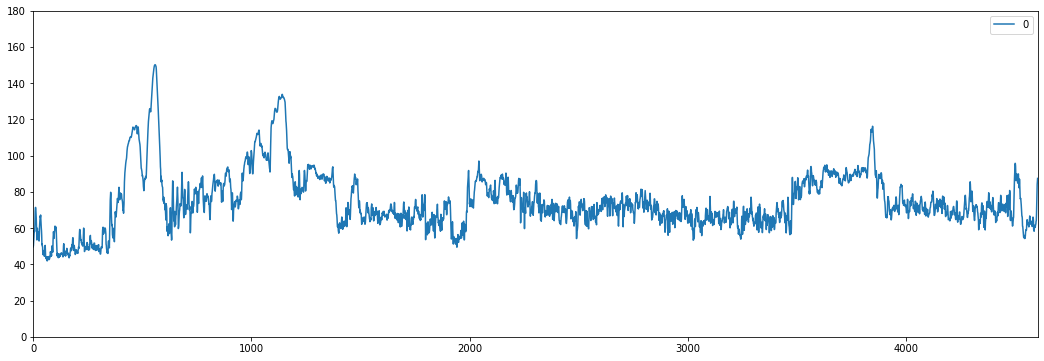

In [4]:
data_exp_label = pd.DataFrame(data_exp['label'])
data_exp_label.plot(yticks=range(0,200,20),figsize=(18,6))


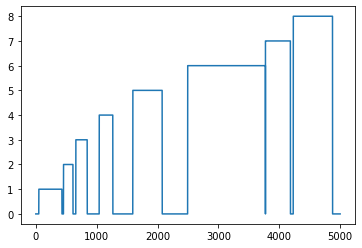

In [5]:
data_exp_act = pd.DataFrame(data_exp['activity'])
plt.plot(data_exp_act.index*(5000/len(data_exp_act)), data_exp_act)

plt.show()

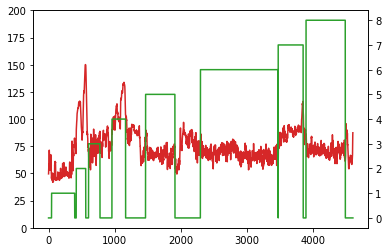

In [6]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.plot(data_exp_label.index, data_exp_label, color=color)
ax1.tick_params(axis='y')
ax1.set_yticks(range(0,225,25))


ax2 = ax1.twinx()

color = 'tab:green'
ax2.plot(data_exp_act.index*(len(data_exp_label)/len(data_exp_act)), data_exp_act, color=color)
ax2.tick_params(axis='y')

plt.show()

### La dernière figure montre bien le lien entre l'activité physique du sujet et son rythme cardiaque
### En se basant uniquement sur ce graphe on pourrait se dire qu'il suffit uniquement de prendre le rythme cardiaque pour définir l'acitivité en cours, cependant le rythme dépend aussi de nombreuses variables telles que le poids, ou encore la taille et il sera donc nécessaire de vérifier la corrélation de toutes ces variables avec l'activité

# Regroupement de toutes les données

In [7]:
allusers = {}
for i in range(1,16):
    print(i)
    allusers[i] = pd.read_pickle(f"./S"+str(i)+"/S"+str(i)+".pkl")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [8]:
df = pd.DataFrame(alldatas)

NameError: name 'alldatas' is not defined

In [ ]:
df

In [ ]:
df.sum

## Nous avons deux problématiques afin de pouvoir insérer ces données dans un modèle : premièrement, il faut mettre les données à la même échelle, il faut ensuite sortir toutes les données de leurs listes respectives

In [ ]:
def to_4h(data, freq):
    to_scale = []
    n_div = int(freq/4)
    
    for i in range(0, len(data), n_div):
        to_scale.append((sum(data[i:i+n_div])/n_div))
    return to_scale

In [ ]:
for i,j in allusers.items():
    dact = pd.DataFrame.from_dict(j["activity"])
    dact.rename(columns={0:'activity'}, inplace=True)
    temp=j['label'].repeat(len(j['activity'])/len(j['label'])).tolist()
    #On obtient pas le bon nombre de valeur car il prend l'entier inférieur. 
    #Afin de ne pas fausser les valeurs on rajoute la moyenne des valeurs 
    temp.extend([statistics.mean(j['label'])] * (len(j['activity'])-len(temp)))
    dlabel = pd.DataFrame(temp)
    dlabel.rename(columns={0:'label'}, inplace=True)
    
    j["signal"]["chest"]["ECG"] = to_4h(j["signal"]["chest"]["ECG"], 700)
    decg =pd.DataFrame.from_dict(j["signal"]["chest"]["ECG"])
    decg.rename(columns={0:'ecg'}, inplace=True)
    
    j["signal"]["chest"]["ACC"] = to_4h(j["signal"]["chest"]["ACC"], 700)
    dchest = pd.DataFrame.from_dict(j["signal"]["chest"]["ACC"])
    dchest.rename(columns={0:'xchest',1:'ychest',2:'zchest'}, inplace=True)
    
    j["signal"]["chest"]["Resp"] = to_4h(j["signal"]["chest"]["Resp"], 700)    
    dresp=pd.DataFrame.from_dict(j["signal"]["chest"]["Resp"])
    dresp.rename(columns={0:'resp'}, inplace=True)

    chestall = pd.concat([dchest, decg , dresp], axis=1)
    
    
    dsig=pd.DataFrame.from_dict(j["signal"]["wrist"]["TEMP"])
    dsig.rename(columns={0:'temp'}, inplace=True)
    
    j["signal"]["wrist"]["ACC"] = to_4h(j["signal"]["wrist"]["ACC"], 32)
    dwrist = pd.DataFrame.from_dict(j["signal"]["wrist"]["ACC"])
    dwrist.rename(columns={0:'xwrist', 1:'ywrist', 2:'zwrist'}, inplace=True)
    
    j["signal"]["wrist"]["BVP"] = to_4h(j["signal"]["wrist"]["BVP"], 64)
    dbvp=pd.DataFrame.from_dict(j["signal"]["wrist"]["BVP"])
    dbvp.rename(columns={0:'bvp'}, inplace=True )
    
    wristall = pd.concat([dwrist, dbvp, dsig], axis=1)
    
    
    
    #On multipplie par la taille de dfallwrist afin de répéter sur toutes les lignes l'id des sujets
    #C'est le même principe pour les informations des sujets
    did=pd.DataFrame([j['subject'][1:]] * len(wristall))
    did.rename(columns = {0:'IDSubject'}, inplace=True)
    
    ques = j["questionnaire"]
    dques = pd.DataFrame.from_dict(ques, orient = 'index').T
    dques = pd.concat([dques]*len(wristall), ignore_index=True)
    

    dfdatas = pd.concat([did,dques,dact,dlabel,chestall, wristall], axis=1)
    
    allusers[i] = dfdatas


data_concat = pd.concat([allusers[1],allusers[2],allusers[3],allusers[4],allusers[5],allusers[6],allusers[7],allusers[8],allusers[9],allusers[10],allusers[11],allusers[12],allusers[13],allusers[14],allusers[15]])
data_concat

In [ ]:
corr = data_concat.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
x = data_concat[['AGE','SPORT','WEIGHT','HEIGHT','label','zchest','zwrist','temp']]
y = data_concat[['activity']]

## Maintenant qu'on a fait le preprocessing, on peut passer au modèle

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y.values.ravel(),random_state = 211308)

In [ ]:
model = RandomForestClassifier(n_estimators=20)
model.fit(x_train,y_train)

In [ ]:
model.score(x_test, y_test)

In [ ]:
print(classification_report(y_test, model.predict(x_test)))

In [ ]:
gboostmodel = GradientBoostingClassifier(n_estimators=100, random_state=211308)
gboostmodel.fit(x_train,y_train)

In [ ]:
gboostmodel.score(x_test,y_test)

In [ ]:
print(classification_report(y_test, gboostmodel.predict(x_test)))

## Les deux modèles donnent de bons résultats, avec des résultats surprenamment haut du RandomForest, notamment pour la montée d'escalier avec une précision et un recall parfaits

In [ ]:
classimodelname = "rfclassi.sav"
pickle.dump(model, open(classimodelname, 'wb'))

In [ ]:
boostmodelname = "boostclassi.sav"
pickle.dump(gboostmodel, open(boostmodelname, 'wb'))